In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from IPython.display import clear_output

# core MAGI class
from python_magi import MAGI

/opt/homebrew/Caskroom/miniforge/base/envs/test/lib/python3.10/site-packages/python_magi/magi.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Introduction:
The purpose of this vignette is to provide a quick-start guide to using the `python_magi` module, namely the core `MAGI` method class, for solving the ordinary differential equation (ODE) inverse problem. The `python_magi` package builds on the original MAGI method described by [Yang et al. (2020).](https://www.pnas.org/doi/10.1073/pnas.2020397118)

If you have any questions or concerns, please reach out to [skylerw@stanford.edu](skylerw@stanford.edu).

# Example A: SEIR System with All Components Fully-Observed

## 1. Governing Equations for the SEIR System

We begin by encoding the [governing ODE equations for the SEIR system](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) into a broadcastable form for compatibility with `TensorFlow Probability` vectorization. We reduce the degrees of freedom by noting that $S$ is a deterministic function of $E, I, R$: namely, $S = 1 - E - I - R$, if we let $S,E,I,R$ represent the proportions of the population in each compartment.

In [2]:
# 3-component model governing the SEIR system, appropriate for <tensorflow vectorization>
def f_vec(t, X, thetas):
    '''
    1. X - array containing (E, I, R) components. Suppose it is (N x D) for vectorization.
    2. theta - array containing (beta, gamma, sigma) components.
    3. Note that N_pop = 1.0, and that S is deterministic: S = 1 - (E + I + R)
    '''
    # implicitly compute S
    S = 1.0 - tf.reshape(tf.reduce_sum(X, axis=1), shape=(-1, 1))
    return tf.concat([(thetas[0] * S * X[:,1:2]) - (thetas[2] * X[:,0:1]), # dE/dt = bSI - sE
                      (thetas[2] * X[:,0:1]) - (thetas[1] * X[:,1:2]), # dI/dt = sE - gI
                      (thetas[1] * X[:,1:2])], # dR/dt = g*I
                     axis=1)

## 2. Generating Dataset and Simulating Missingness

Below, we load in a sample ground truth dataset (generated using numerical integration), thinning out the observations to simulate real-world conditions.

In [3]:
# initial data settings
d_obs = 20 # no. of observations per unit time
t_max = 4.0 # simulate observations from T=0 to T=4.

# which components are observed? For this first example, let's say everything is observed.
comp_obs = [True, True, True]

# load in our data, thinning based on desired number of noisy observations
raw_data = pd.read_csv('data/SEIR_data.csv').query(f"t <= {t_max}")
obs_data = raw_data.iloc[::int((raw_data.index.shape[0] - 1) / (d_obs * t_max))]

# extract out the time vector + noisy observations
ts_obs = obs_data.t.values.astype(np.float64)
X_obs = obs_data[["E_obs", "I_obs", "R_obs"]].to_numpy().astype(np.float64) # S is implicit!

# make certain components missing if necessary
for i, comp_obs_val in enumerate(comp_obs):
    if comp_obs_val != True:
        X_obs[:,i] = np.nan

## 3.  MAGI Model Fitting

Next, in just four lines of code modeled after `scikit-learn`'s syntax, we a) instantiate our MAGI model, b) fit the Matern kernel hyperparameters and other initial values for observed and unobserved components, and c) perform inference via [NUTS](https://arxiv.org/abs/1111.4246) sampling on the posterior distribution.

In [4]:
# create our model - f_vec is the ODE governing equations function defined earlier.
model = MAGI(D_thetas=3, ts_obs=ts_obs, X_obs=X_obs, bandsize=80, f_vec=f_vec)

# fit Matern kernel hyperparameters (phi1, phi2) as well as (Xhat_init, sigma_sqs_init, thetas_init)
model.initial_fit(discretization=1, verbose=True)

# clear console for pretty output
clear_output(wait=True)

# collect our samples from NUTS posterior sampling
results = model.predict(num_results=2000, num_burnin_steps=2000, verbose=True)

Starting NUTS posterior sampling ...


2025-03-31 12:28:11.195107: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:108] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed


Finished sampling in 0.83 minutes.


## 4. Checking Results

Below, we visualize the inferred trajectories from our NUTS posterior samples by plotting the mean predicted trajectories and the 95% predictive intervals against the ground truth and our noisy observations. We also check our mean inferred parameter values $\hat{\theta}$ vs. their true values.

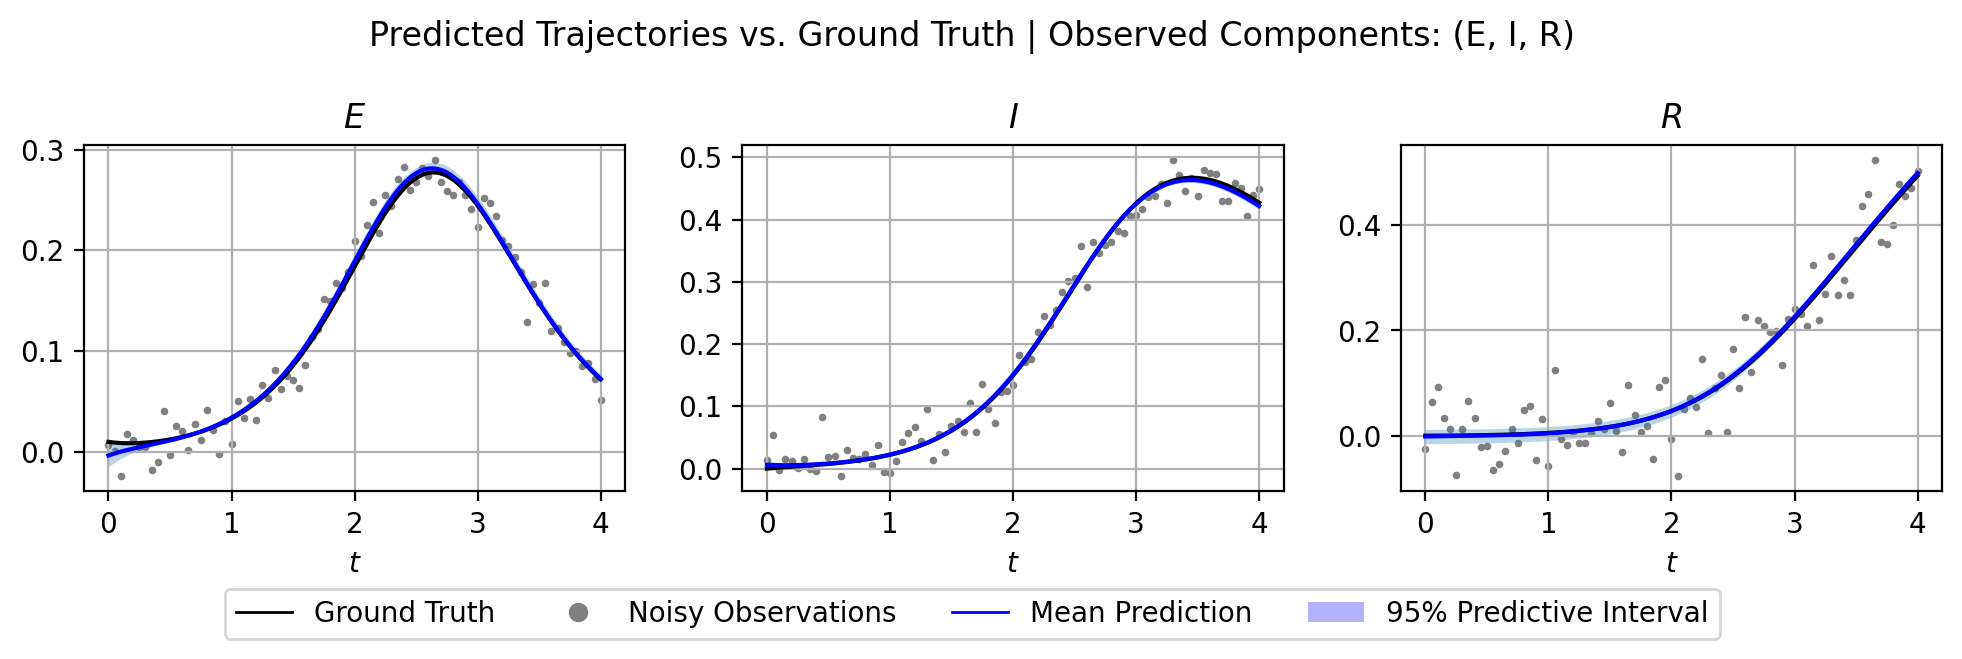

In [5]:
# visualize our trajectories
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(10, 3))

# get our timesteps, mean trajectory predictions, and 2.5% + 97.5% trajectory predictions
I = results["I"].flatten()
Xhat_means = results["X_samps"].mean(axis=0)
Xhat_intervals = np.quantile(results["X_samps"], q=[0.025, 0.975], axis=0)

# go through each component and plot
for i, comp in enumerate(["$E$", "$I$", "$R$"]):
    
    # plot the ground truth + noisy observations
    if comp_obs[i]:
        ax[i].scatter(ts_obs, X_obs[:,i], s=3, color="grey")
    ax[i].plot(raw_data.t, raw_data[["E_true", "I_true", "R_true"][i]], color="black")
    
    # plot mean trajectory + 95% predictive interval
    ax[i].plot(I, Xhat_means[:,i], color="blue")
    ax[i].fill_between(I, Xhat_intervals[0,:,i], Xhat_intervals[1,:,i], alpha=0.3)
    ax[i].set_title(comp); ax[i].set_xlabel("$t$")
    ax[i].grid()
    
# shared legend + beautify
observed_components_desc = "(E, I, R)"
plt.suptitle(f"Predicted Trajectories vs. Ground Truth | Observed Components: {observed_components_desc}")
custom_lines = [Line2D([0], [0], color="black", linewidth=1.0, alpha=1.0, label="Ground Truth"),
                Line2D([0], [0], color="grey", marker="o", linestyle="None", label="Noisy Observations"),
                Line2D([0], [0], color="blue", linewidth=1.0, alpha=1.0, label="Mean Prediction"),
                Patch(facecolor="blue", alpha=0.3, label="95% Predictive Interval")]
fig.legend(handles=custom_lines, loc="lower center", ncol=4, fontsize=10, bbox_to_anchor=(0.5, -0.075))
plt.tight_layout()
plt.show()

In [6]:
# check our parameters too
mean_thetas_pred = results["thetas_samps"].mean(axis=0)

print("Estimated Parameters:")
print(f"- Beta: {np.round(mean_thetas_pred[0], 3)} (Predicted) vs. 6.0 (Actual).")
print(f"- Gamma: {np.round(mean_thetas_pred[1], 3)} (Predicted) vs. 0.6 (Actual).")
print(f"- Sigma: {np.round(mean_thetas_pred[2], 3)} (Predicted) vs. 1.8 (Actual).")

Estimated Parameters:
- Beta: 6.087 (Predicted) vs. 6.0 (Actual).
- Gamma: 0.608 (Predicted) vs. 0.6 (Actual).
- Sigma: 1.772 (Predicted) vs. 1.8 (Actual).


# Example B: (Chaotic) Lorenz System with Missing Components

## 1. Governing Equations for the SEIR System

We begin by encoding the [governing ODE equations for the Lorenz system](https://en.wikipedia.org/wiki/Lorenz_system) into a broadcastable form for compatibility with `TensorFlow Probability` vectorization, with components $X, Y, Z$.

In [7]:
# model governing the Lorenz system, appropriate for tensorflow vectorization
def f_vec(t, X, thetas):
    '''
    1. X - array containing (X, Y, Z) components. Suppose it is (N x D) for vectorization.
    2. theta - array containing (beta, rho, sigma) components.
    '''
    return tf.concat([thetas[2] * (X[:,1:2] - X[:,0:1]), # dx/dt = sigma * (y-x)
                      X[:,0:1] * (thetas[1] - X[:,2:3]) - X[:,1:2], # dy/dt = x * (rho - z) - y
                      X[:,0:1]*X[:,1:2] - thetas[0]*X[:,2:3], # dz/dt = x*y - beta*z
                     ], axis=1)

## 2. Generating Dataset and Simulating Missingness

Similar to the SEIR example, we load in a sample ground truth dataset (generated using numerical integration), thinning out the observations to simulate real-world conditions.

In [8]:
# initial data settings
d_obs = 20 # no. of observations per unit time
t_max = 8.0 # simulate observations from T=0 to T=8.

# which components are observed? Suppose X is unobserved!
comp_obs = [False, True, True]

# load in our data, thinning based on desired number of noisy observations
raw_data = pd.read_csv('data/Lorenz_data.csv').query(f"t <= {t_max}")
obs_data = raw_data.iloc[::int((raw_data.index.shape[0] - 1) / (d_obs * t_max))]

# extract out the time vector + noisy observations
ts_obs = obs_data.t.values.astype(np.float64)
X_obs = obs_data[["X_obs", "Y_obs", "Z_obs"]].to_numpy().astype(np.float64) # S is implicit!

# make certain components missing if necessary
for i, comp_obs_val in enumerate(comp_obs):
    if comp_obs_val != True:
        X_obs[:,i] = np.nan

## 3.  MAGI Model Fitting

MAGI can still solve the ODE inverse problem even when some components of the system are completely unobserved. It will handle missing data automatically via its `initial_fit` routines and sample these components during the posterior inference phase, too.

In [9]:
# create our model - f_vec is the ODE governing equations function defined earlier.
model = MAGI(D_thetas=3, ts_obs=ts_obs, X_obs=X_obs, bandsize=80, f_vec=f_vec)

# fit Matern kernel hyperparameters (phi1, phi2) as well as (Xhat_init, sigma_sqs_init, thetas_init)
model.initial_fit(discretization=1, verbose=True)

# clear console for pretty output
clear_output(wait=True)

# collect our samples from NUTS posterior sampling
results = model.predict(num_results=2000, num_burnin_steps=2000, verbose=True)

Starting NUTS posterior sampling ...
Finished sampling in 5.5 minutes.


## 4. Checking Results

Below, we visualize the inferred trajectories from our NUTS posterior samples by plotting the mean predicted trajectories and the 95% predictive intervals against the ground truth and our noisy observations. We also check our mean inferred parameter values $\hat{\theta}$ vs. their true values. 

* *Note that subplots without noisy observations scatter-plotted indicate that this component was simulated as completely unobserved.*

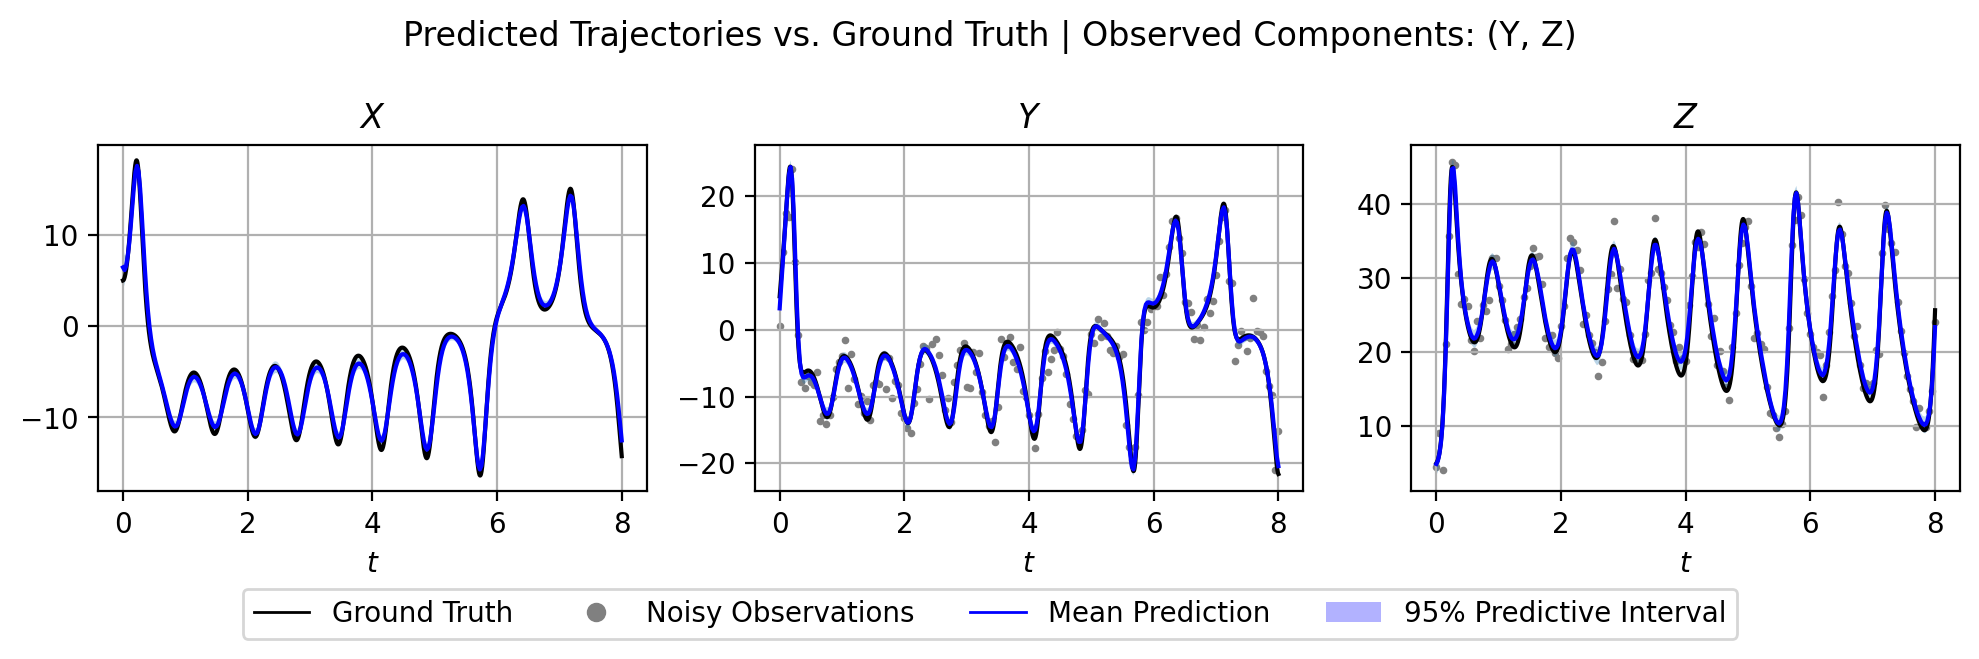

In [10]:
# visualize our trajectories
fig, ax = plt.subplots(1, 3, dpi=200, figsize=(10, 3))

# get our timesteps, mean trajectory predictions, and 2.5% + 97.5% trajectory predictions
I = results["I"].flatten()
Xhat_means = results["X_samps"].mean(axis=0)
Xhat_intervals = np.quantile(results["X_samps"], q=[0.025, 0.975], axis=0)

# go through each component and plot
for i, comp in enumerate(["$X$", "$Y$", "$Z$"]):
    
    # plot the ground truth + noisy observations
    if comp_obs[i]:
        ax[i].scatter(ts_obs, X_obs[:,i], s=3, color="grey")
    ax[i].plot(raw_data.t, raw_data[["X_true", "Y_true", "Z_true"][i]], color="black")
    
    # plot mean trajectory + 95% predictive interval
    ax[i].plot(I, Xhat_means[:,i], color="blue")
    ax[i].fill_between(I, Xhat_intervals[0,:,i], Xhat_intervals[1,:,i], alpha=0.3)
    ax[i].set_title(comp); ax[i].set_xlabel("$t$")
    ax[i].grid()
    
# shared legend + beautify
observed_components_desc = "(Y, Z)"
plt.suptitle(f"Predicted Trajectories vs. Ground Truth | Observed Components: {observed_components_desc}")
custom_lines = [Line2D([0], [0], color="black", linewidth=1.0, alpha=1.0, label="Ground Truth"),
                Line2D([0], [0], color="grey", marker="o", linestyle="None", label="Noisy Observations"),
                Line2D([0], [0], color="blue", linewidth=1.0, alpha=1.0, label="Mean Prediction"),
                Patch(facecolor="blue", alpha=0.3, label="95% Predictive Interval")]
fig.legend(handles=custom_lines, loc="lower center", ncol=4, fontsize=10, bbox_to_anchor=(0.5, -0.075))
plt.tight_layout()
plt.show()

In [11]:
# check our parameters too
mean_thetas_pred = results["thetas_samps"].mean(axis=0)

print("Estimated Parameters:")
print(f"- Beta: {np.round(mean_thetas_pred[0], 3)} (Predicted) vs. 2.66 (Actual).")
print(f"- Rho: {np.round(mean_thetas_pred[1], 3)} (Predicted) vs. 28.0 (Actual).")
print(f"- Sigma: {np.round(mean_thetas_pred[2], 3)} (Predicted) vs. 10.0 (Actual).")

Estimated Parameters:
- Beta: 2.566 (Predicted) vs. 2.66 (Actual).
- Rho: 28.166 (Predicted) vs. 28.0 (Actual).
- Sigma: 8.602 (Predicted) vs. 10.0 (Actual).
